# Atacando un problema de clasificación: predicción de días lluviosos (primera parte)

En este primer notebook vamos a investigar cómo podemos mejorar las predicciones que hicimos en la clase pasada con regresión logística. En particular, vamos a investigar el efecto de los datos desbalanceados.

Recordemos de la clase pasa que cargamos un archivo de INTA con distintos campos asociados a observaciones metereológicas.

In [ ]:
# Como siempre, tratamos de traer todos los paquetes al ppio
from google.colab import drive # Para montar nuestro drive en la consola
import matplotlib.pylab as plt # Para gráficos
plt.rcParams.update({'font.size': 22})
import numpy as np # Para manejo de arrays, operaciones matemáticas, etc.
from sklearn.linear_model import LogisticRegression # El método de regresión logística que vamos a usar
!pip install --upgrade pandas
!pip install --upgrade xlrd
import pandas as pd # Para manejo de base de datos

drive.mount('/content/drive') # Montamos nuestra unidad de Google Drive

filename = '/content/drive/My Drive/LaboDatos2022/datosDiariosSanFernandoINTA.xls'

d = pd.read_excel(filename) # Levantamos los datos, en este caso, con el método pd.read_excel
d.head() # Mostramos las primeras líneas, para darnos una idea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Fecha,Temperatura_Abrigo_150cm,Temperatura_Abrigo_150cm_Maxima,Temperatura_Abrigo_150cm_Minima,Temperatura_Intemperie_5cm_Minima,Temperatura_Intemperie_50cm_Minima,Temperatura_Suelo_5cm_Media,Temperatura_Suelo_10cm_Media,Temperatura_Inte_5cm,Temperatura_Intemperie_150cm_Minima,...,Duracion_Follaje_Mojado,Velocidad_Viento_200cm_Media,Direccion_Viento_200cm,Velocidad_Viento_1000cm_Media,Direccion_Viento_1000cm,Velocidad_Viento_Maxima,Presion_Media,Radiacion_Global,Horas_Frio,Unidades_Frio
0,2018-02-08 00:00:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,,NaN,,NaN,NaN,NaN,NaN,NaN
1,2018-02-09 00:00:00.0,23.80764,28.6,20.4,NaN,NaN,NaN,26.21042,NaN,NaN,...,NaN,1.332639,C,1.665799,C,19.3,NaN,NaN,0.0,-23.904030
2,2018-02-10 00:00:00.0,24.51389,31.7,19.4,NaN,NaN,NaN,26.45972,NaN,NaN,...,NaN,1.638195,C,2.047743,C,19.0,NaN,NaN,0.0,-23.904030
3,2018-02-11 00:00:00.0,19.50139,24.2,15.1,NaN,NaN,NaN,24.66320,NaN,NaN,...,NaN,3.247224,E,4.059030,C,20.4,NaN,NaN,0.0,-15.106020
4,2018-02-12 00:00:00.0,16.70625,24.6,9.5,NaN,NaN,NaN,22.63611,NaN,NaN,...,NaN,1.027778,C,1.284722,C,13.4,NaN,NaN,0.0,-5.394994


Luego, filtramos el dataframe descartando columnas con datos faltantes,  seleccionamos un subconjunto de columnas, y las renombramos.

In [ ]:
d_filtrado = d[['Temperatura_Abrigo_150cm_Maxima',
                'Temperatura_Abrigo_150cm_Minima',
                'Precipitacion_Pluviometrica',
                'Velocidad_Viento_Maxima',
                'Rocio_Medio',
                'Humedad_Media']].dropna().copy() # Nos quedamos con ciertos campos del data set, para facilitar el trabajo. Y para limitarlo.
                                                  # Notar que primero aplicamos el método .dropna() para eliminar filas que tengan alguna columna con NaN
                                                  # Ademas, el metodo copy() nos asegura que estemos creando un nuevo dataframe
d_filtrado.rename({'Temperatura_Abrigo_150cm_Maxima' : 'temperaturaMaxima',
                   'Temperatura_Abrigo_150cm_Minima' : 'temperaturaMinima',
                   'Precipitacion_Pluviometrica' : 'precipitacion',
                   'Humedad_Media' : 'humedad',
                   'Rocio_Medio' : 'rocio',
                   'Velocidad_Viento_Maxima' : 'viento'},
                  axis = 1,
                  inplace = True) # Esto toma como input un diccionario en el cual las llaves son los nombres actuales de columnas, y los valores los nombres nuevos (a los que queremos renombrar)
                                  # axis = 1 es porque queremos renombrar columnas, y inplace=True es porque queremos "pisar" el dataframe al renombrarlo

Finalmente, construimos una variable con las etiquetas de los días lluviosos.




In [ ]:
d_filtrado['llueveNollueve'] = 0 # empezamos con una columna llena de 0.
indice =  d_filtrado['precipitacion'] > 0  # esto me da los valores del indice para los cuales hay precipitacion mayor a 0
d_filtrado.loc[indice, 'llueveNollueve'] = 1 # entonces para esos valores del indice pongo 1, porque en el dia correspondiente, llovio

d_filtrado['llueveNollueve'].value_counts()

0    717
1    337
Name: llueveNollueve, dtype: int64

# Mejorando cómo medimos el score de clasificación

Empecemos a partir del intento por predecir los días de lluvia en base a dos variables: temperatura mínima y humedad.

Esto lo realizabamos mediante el siguiente código:

In [ ]:
# Definamos la matriz X
campos = ['temperaturaMinima',
          'humedad'] # Lista que contiene las features de interés
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = d_filtrado['llueveNollueve'] # Nuestra etiqueta sigue siende la misma de antes

regLog = LogisticRegression(penalty = 'none') # Inicializamos nuevamente el modelo
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
score = regLog.score(X,y) # Calculamos el score

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas

El score del modelo es de: 0.7125


Obtuvimos un score de 0.7125. Recordemos que el score es simplemente la cantidad de aciertos que obtuvimos dividido por la cantidad total de casos. En esta oportunidad, acertamos aproximadamente a un 70% de los casos. Al principio podría parecer que no está tan mal, pero esto es engañoso. El score con el que tenemos que comparar no es 50%, porque el dataset no está balanceado. Por ejemplo, el clasificador trivial que dice que nunca llueve, tiene una precisión de aproximadamente 0.68.

En realidad, nos gustaría tener una idea más detallada de en cuántos días que llovía nuestro clasificador dio el resultado correcto, y lo mismo para días que no llovío.

Digamos que los días sin lluvias son **negativos** y los días con lluva son **positivos**.

1.   Si el clasificador dice que no llueve y no llueve, es un **verdadero negativo**
2.   Si el clasificador dice que no llueve y llueve, es un **falso negativos**
3.   Si el clasificador dice que llueve y llueve, es un **verdadero positivo**
4.   Si el clasificador dice que llueve y no llueve, es un **falso positivo**

Esto se puede resumir en la **matriz de confusión**:


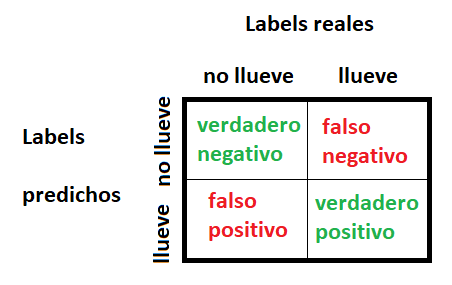

In [ ]:
from sklearn.metrics import confusion_matrix

ypred = regLog.predict(X) # con esto obtengo la predicción de las etiquetas en base a mis datos

print(ypred)

cm = confusion_matrix(ypred, y) # primera entrada son las etiquetas predichas, segunda son las reales

print(cm)

[0 0 0 ... 0 0 0]
[[643 229]
 [ 74 108]]


Podemos armar una versión normalizada por filas, para independizarnos de los números y hablar de las tasas de clasificación.

In [ ]:
cm = confusion_matrix(ypred, y, normalize='true') # primera entrada son las etiquetas predichas, segunda son las reales

print(cm)

[[0.73738532 0.26261468]
 [0.40659341 0.59340659]]


Es decir que en un 73% de las veces, si el algoritmo dijo no que llovía le pegó, y en 59% de las veces cuando dijo que llovía.

La matriz de confusión tiene 4 entradas. Podríamos querer resumir la performance con un único número. Ya vimos que el score estándar ("accuracy") no es tan buena medida para datasets desbalanceados. Hay muchas formas de definir números que reflejen la performance del algoritmo, incluso en datasets no balanceados.

Antes de hacerlo, introducimos dos métricas conocidas como sensibilidad y especificidad:

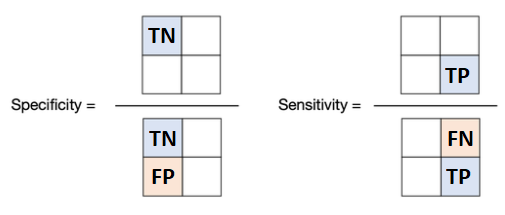

Este diagrama ilustra como se computan ambos a partir de la matriz de confusión.

La sensibilidad responde la pregunta, ¿qué proporción de los casos positivos pude detectar realmente?

La especificidad responde la pregunta, ¿qué proporción de los casos negativos pude detectar realmente?

Introducimos entonces la "accuracy" balanceada como el promedio de estas dos métricas.

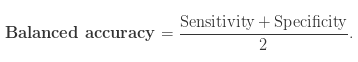

In [ ]:
cm = confusion_matrix(ypred, y)

def balanced_accuracy(cm):
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

metricas = balanced_accuracy(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))
print('BA del modelo es de: {}'.format(round(metricas[2],4)))

Matriz de confusion del modelo es:
[[643 229]
 [ 74 108]]
Sensibilidad del modelo es de: 0.3205
Especificidad del modelo es de: 0.8968
BA del modelo es de: 0.6086


# Balanceando por subsampleado

Volvamos a graficar el espacio bidimensional de temperatura mínima vs. presión, tal como hicimos al final de la clase anterior, excepto que ahora vamos a definir una función para hacerlo, porque vamos a tener que hacerlo muchas veces:




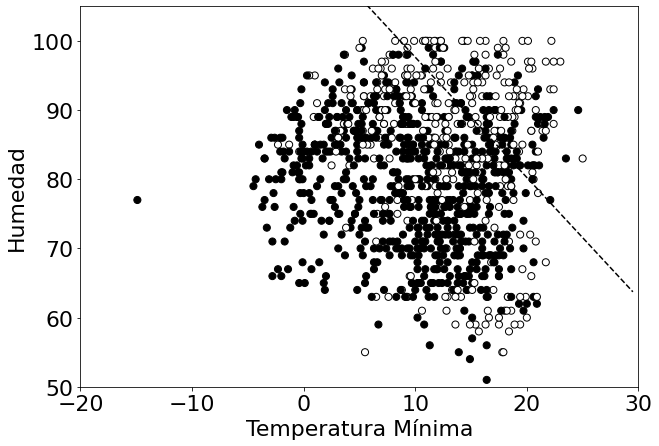

In [ ]:
def grafica_logred_2D(X,y,regLog):

  beta_0 = regLog.intercept_ # El beta 0
  beta_1 = regLog.coef_[0][0] # El coeficiente beta_1
  beta_2 = regLog.coef_[0][1] # El coeficiente beta_2

  fig, ax = plt.subplots(figsize = (10,7))


  ax.scatter(X[:,0], # Ploteamos la primera columna de nuestra matriz X. Osea, la temperaturaMinima
            X[:,1], # Ploteamos la segunda columna de nuestra matriz X. Osea, la humedad
            c = y, # Les damos color a los puntos según la etiqueta real
            cmap = 'gray', # El mapa de color
            s=50,
            edgecolors='black')
  ax.set_xlabel('Temperatura Mínima') # Etiqueta del eje x
  ax.set_ylabel('Humedad') # Etiqueta del eje y

  # Plotear la curva acá, no sería de mucho interés. Sí podríamos colorear un área como representación de la función P: R² ---> R
  # Plotiemos la frontera de decisión

  x_1_test = np.arange(-20,30,0.5) # Generamos unas temperaturas de prueba, para plotear la definición de frontera en el caso de dos features como vimos en la teórica
  ax.plot(x_1_test,
          - (beta_0 + x_1_test * beta_1) / beta_2, # Generamos el la recta que calculamos en la teórica
          linestyle = 'dashed',
          color = 'k')
  #ax.legend()
  ax.axis([-20,30,50,105]) # Seteamos los límites de los ejes
  plt.show()


# ahora si, llamamos la funcion
grafica_logred_2D(X,y,regLog)

Vemos inmediatamente un problema: la recta tiende a asegurarse que los puntos celestes (días sin lluvia) esten bien clasificados, a expensas de los días amarillos (con lluvia). **Esto es porque hay muchos más días sin lluvia en el dataset y por lo tanto es una mejor estrategía clasificarlos correctamente para reducir la función de pérdida.**

Empecemos con una forma ingenua de atacar este problema: descartemos aleatoriamente datos de días sin lluvia hasta que la cantidad de etiquetas sea la misma en los dos grupos.

In [ ]:
import numpy as np

# indices de cada una de las clases
i_class0 = np.where(y == 0)[0]
i_class1 = np.where(y == 1)[0]

# numero de observaciones en cada una de las clases
n_class0 = len(i_class0)
n_class1 = len(i_class1)

# seleccionar un subconjunto de indices de clase 0 (dias sin lluvia) del tamaño del indice de clase 1 (dias con lluvia) al azar
i_class0_downsampled = np.random.choice(i_class0, size=n_class1, replace=False)

indices_row = np.concatenate((i_class0_downsampled, i_class1), axis=0) # armo los indices finales concatenando todo de nuevo
X_balance = X[indices_row, 0:] # selecciono en base a esos indices las filas correspondientes
y_balance = np.asarray(y)[indices_row] # lo mismo con el vector de targers

print(len(y_balance[y_balance==0])) # veo que efectivamente tengo la misma cantidad de 0 que 1
print(len(y_balance[y_balance==1]))

337
337


Ahora, vuelvo a entrenar y evaluar el modelo con los datos balanceados.

In [ ]:
regLog = LogisticRegression(penalty = 'none') # Inicializamos nuevamente el modelo
regLog.fit(X_balance, y_balance) # Ajustamos el modelo cnon los datos balanceados
score = regLog.score(X_balance,y_balance) # Calculamos el score con los datos balanceados
beta_0 = regLog.intercept_ # El beta 0
beta_1 = regLog.coef_[0][0] # El coeficiente beta_1
beta_2 = regLog.coef_[0][1] # El coeficiente beta_2

ypred_balance = regLog.predict(X_balance) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm = confusion_matrix(ypred_balance, y_balance) # primera entrada son las etiquetas predichas, segunda son las reales
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))
print('BA del modelo es de: {}'.format(round(metricas[2],4)))

El score del modelo es de: 0.6558
Matriz de confusion del modelo es:
[[221 116]
 [116 221]]
Sensibilidad del modelo es de: 0.6558
Especificidad del modelo es de: 0.6558
BA del modelo es de: 0.6558


Observemos que como balanceamos los datos, ahora BA y "accuracy" son iguales. Ademas, cometemos la misma cantidad de errores en ambas categorias (dias con y sin lluvia).

Veamos como se ve la recta de decision:

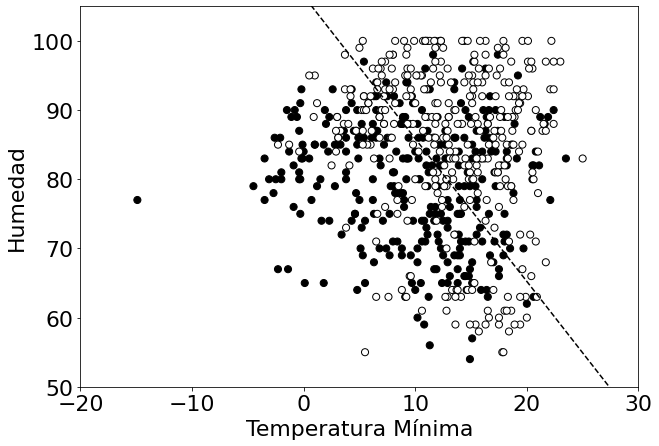

In [ ]:
# Miremos esto en un gráfico

grafica_logred_2D(X_balance,y_balance,regLog)

Claramente la frontera ahora pasa por el centro de la nube de puntos.

# Balanceando por frecuencia de clases

El problema con la forma anterior de balancear el dataset es que tuvimos que tirar datos a la basura (y esto tuvimos que hacerlo al azar).

Hay una  mejor forma de hacer esto, que es adaptar la penalización por clasificación incorrecta dependiendo de la frecuencia con la que aparece cada etiqueta. Es decir, que si una etiqueta es más frecuente que la otra, hay menor penalización asociada. Esto lo hacemos con la variable class_weight del objeto de regresión logística de scikit-learn.

In [ ]:
regLog = LogisticRegression(penalty = 'none', class_weight='balanced') # Inicializamos nuevamente el modelo. Pedimos balancear las clases.
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
score = regLog.score(X,y) # Calculamos el score
beta_0 = regLog.intercept_ # El beta 0
beta_1 = regLog.coef_[0][0] # El coeficiente beta_1
beta_2 = regLog.coef_[0][1] # El coeficiente beta_2

ypred = regLog.predict(X) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm = confusion_matrix(ypred, y) # primera entrada son las etiquetas predichas, segunda son las reales
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))
print('BA del modelo es de: {}'.format(round(metricas[2],4)))

El score del modelo es de: 0.667
Matriz de confusion del modelo es:
[[479 113]
 [238 224]]
Sensibilidad del modelo es de: 0.6647
Especificidad del modelo es de: 0.6681
BA del modelo es de: 0.6664


En este caso, nuevamente son similares la "balanced accuracy" el score del modelo ("accuracy" a secas).

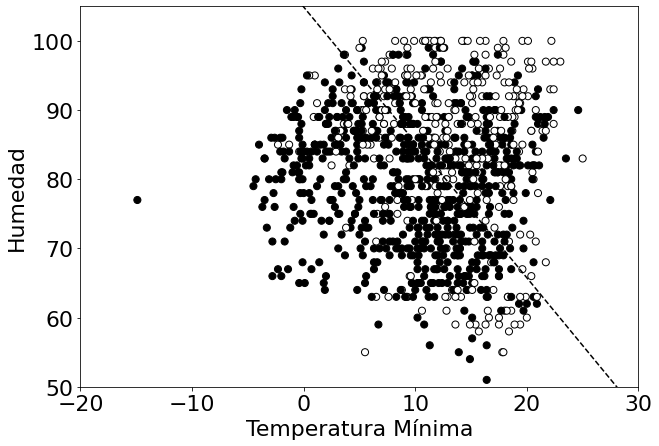

In [ ]:
# Miremos esto en un gráfico

grafica_logred_2D(X,y,regLog)

Esto fuerza a la recta a pasar por entre la nube de puntos debido a la importancia relativa que le da a los errores de clasficación de cada una de las clases.

# Tipos de error

Empezamos a darnos cuenta de algo: la forma en que la recta atraviesa la nube de puntos no refleja un único concepto de *performance* del algoritmo, porque ese concepto *no existe*

Supongamos que es muy importante detectar todos los días de lluvia, es decir, si va a llovar es muy importante que el pronóstico diga que hay lluvia (por ejemplo, podemos imaginar un futuro con una lluvia radioactiva que mata a las personas).

Entonces podemos lograr esto poniendo un peso comparativamente más grande a la etiqueta 1 (día con lluvia)



El score del modelo es de: 0.3681
Matriz de confusion del modelo es:
[[ 53   2]
 [664 335]]
Sensibilidad del modelo es de: 0.9941
Especificidad del modelo es de: 0.0739
BA del modelo es de: 0.534


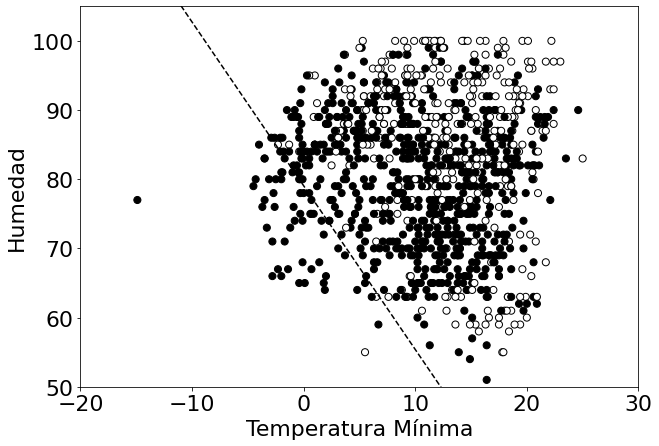

In [ ]:
pesos = {0:0.1, 1:1} # armamos un diccionario donde las llaves son los labels y los valores los pesos para esos labels

regLog = LogisticRegression(penalty = 'none', class_weight=pesos) # Inicializamos nuevamente el modelo.
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
score = regLog.score(X,y) # Calculamos el score
beta_0 = regLog.intercept_ # El beta 0
beta_1 = regLog.coef_[0][0] # El coeficiente beta_1
beta_2 = regLog.coef_[0][1] # El coeficiente beta_2

ypred = regLog.predict(X) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm = confusion_matrix(ypred, y) # primera entrada son las etiquetas predichas, segunda son las reales
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))
print('BA del modelo es de: {}'.format(round(metricas[2],4)))

grafica_logred_2D(X,y,regLog)

Vemos de la matriz de confusión únicamente 2 de los días de lluvia son clasificados erróneamente como días sin lluvia. Por el contrario, dentro de los días de no lluvia, una cantidad muy grande es clasificada como lluvia. Cuando vemos la figura entendemos que pasa: la linea de división está sesgada para que todos los ejemplos de lluvia queden siempre del mismo lado, casi sin clasificaciones equivocadas.

Este clasificador no es muy útil. Es verdad que es muy poco probable que llueva un día y no lo detectemos, pero también es cierto que vamos a estar repletos de falsos positivos, que en la jerga se lo conoce como error **tipo 1**.

Podemos pensar en la posición opuesta: queremos jamás fallar en detectar un día sin lluvia.

El score del modelo es de: 0.6926
Matriz de confusion del modelo es:
[[716 323]
 [  1  14]]
Sensibilidad del modelo es de: 0.0415
Especificidad del modelo es de: 0.9986
BA del modelo es de: 0.5201


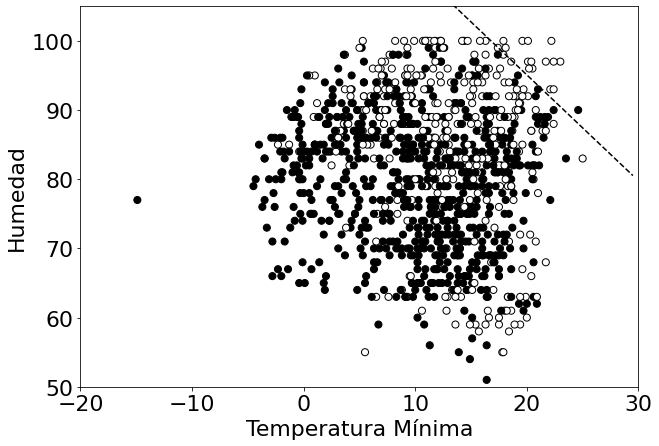

In [ ]:
pesos = {0:1, 1:0.4} # armamos un diccionario donde las llaves son los labels y los valores los pesos para esos labels

regLog = LogisticRegression(penalty = 'none', class_weight=pesos) # Inicializamos nuevamente el modelo.
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
score = regLog.score(X,y) # Calculamos el score
beta_0 = regLog.intercept_ # El beta 0
beta_1 = regLog.coef_[0][0] # El coeficiente beta_1
beta_2 = regLog.coef_[0][1] # El coeficiente beta_2

ypred = regLog.predict(X) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm = confusion_matrix(ypred, y) # primera entrada son las etiquetas predichas, segunda son las reales
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))
print('BA del modelo es de: {}'.format(round(metricas[2],4)))

grafica_logred_2D(X,y,regLog)

Esta situación es similar a la anterior. Ahora la tasa de verdaderos negativos es muy alta, pero a expensas de que también lo sea la tasa de falsos negativos. Esto se conoce en la jerga como **error tipo 2.**

En resúmen, dependiendo de como peso los errores asociados a distintas etiquetas, puedo tratar de que no se me escape ningún caso positivo, pero eso tenderá a aumentar el error **tipo 1**

Alternativamente, puedo tratar de que no se me escape ningún negativo, pero eso tenderá a aumentar el error **tipo 2**

# Para llevarse de este notebook



*   El score por defecto ("accuracy") puede no ser muy bueno para medir la performance de un clasificador si los datos no están balanceados. En ese caso, recomendamos visualizar la matriz de confusión:



```
from sklearn.metrics import confusion_matrix

ypred = regLog.predict(X) # con esto obtengo la predicción de las etiquetas en base a mis datos

cm = confusion_matrix(ypred, y) # primera entrada son las etiquetas predichas, segunda son las reales

print(cm)
```

*   Si queremos resumir la performance en un único número, podemos considerar el promedio de la especificidad y la sensibilidad:

```
def balanced_accuracy(cm):
  sensibilidad = cm[0,0]/(cm[0,0]+cm[1,0])
  especificidad = cm[1,1]/(cm[1,1]+cm[0,1])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]
```

*   Si tenemos datos no balanceados, una opción es subsamplear la clase más prevalente. Pero tiene la desventaja de que perdemos datos. Otra forma de hacerlo es penalizando las clasificaciones erróneas de distinta forma dependiendo de la clase. Se puede hacer tanto balanceado:


```
regLog = LogisticRegression(penalty = 'none', class_weight='balanced') #
```

*   Como por pesos especificados a mano para cada una de las clases:

```
peso = {0:0.5, 1:1}

regLog = LogisticRegression(penalty = 'none', class_weight=pesos) #
```

*   Vimos que hay dos tipos de errores que puedo cometer, asociados a la cantidad de falsos positivos (tipo 1) y falsos negativos (tipo 2).








# Preguntas extra

1.   Supongamos que desarrollás un método para diagnosticar una enfermedad grave, por ejemplo, HIV (la presencia de HIV cuenta  como "positivo"). ¿Qué error te parece más grave: tipo 1 (falsos positivos), tipo 2 (falsos negativos), o ambos por igual?
2.   Supongamos que trabajás programando drones letales dedicados a identificar y asesinar a ciertos criminales prófugos (detectar a un criminal cuenta como "positivo"). ¿Qué error te parece más grave: tipo 1 (falsos positivos), tipo 2 (falsos negativos), o ambos por igual?
3.   Supongamos que desarrollás un sistema automático para detectar y responder a ataques termonucleares a partir de datos de radar (un ataque cuenta como "positivo"). ¿Qué error te parece más grave: tipo 1 (falsos positivos), tipo 2 (falsos negativos), o ambos por igual?

